In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.DataFrame({
    "user_id": [0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3, 4, 5, 5, 5, 5, 5, 1, 0, 2, 2],
    "item_id": [10, 10, 11, 12, 15, 10, 11, 11, 13, 14, 15, 13, 10, 11, 11, 14, 10, 12, 13, 15, 15, 11, 11, 10, 11]
})
data

,user_id,item_id
0,0,10
1,0,10
2,0,11
3,0,12
4,0,15
5,1,10
6,1,11
7,1,11
8,2,13
9,2,14


In [3]:
def draw_distribution(data: pd.DataFrame):
    data.groupby("item_id").size().reset_index().rename(columns={0: "counts"}).sort_values("counts").plot("item_id", kind="bar")

In [4]:
class PercentileItemsFilter:
    def __init__(
            self,
            percentile: float = .99,
            items_proportion: float = 0.5,
            query_column: str = "query_id",
            item_column: str = "item_id"
        ) -> None:
        self.percentile = percentile
        self.items_proportion = items_proportion
        self.query_column = query_column
        self.item_column = item_column

    def transform(self, df: pd.DataFrame):
        items_distribution = df.groupby(self.item_column).size().reset_index().rename(columns={0: "counts"})
        users_distribution = df.groupby(self.query_column).size().reset_index().rename(columns={0: "counts"})
        count_threshold = items_distribution.loc[:, "counts"].quantile(self.percentile)

        df_with_counts = (
            df
            .merge(items_distribution, how="left", on=self.item_column)
            .merge(users_distribution, how="left", on=self.query_column, suffixes=["_items", "_users"])
        )
        long_tail = df_with_counts.loc[df_with_counts["counts_items"] <= count_threshold]
        short_tail = df_with_counts.loc[df_with_counts["counts_items"] > count_threshold]
        short_tail["num_items_to_delete"] = self.items_proportion * (
            short_tail["counts_items"] - long_tail["counts_items"].max()
        )
        short_tail["num_items_to_delete"] = short_tail["num_items_to_delete"].astype("int")
        short_tail = short_tail.sort_values("counts_users", ascending=False)

        def get_mask(x):
            mask = np.ones_like(x)
            threshold = x.iloc[0]
            mask[:threshold] = 0
            return mask

        mask = short_tail.groupby(self.item_column)["num_items_to_delete"].transform(get_mask).astype(bool)
        return pd.concat([long_tail[df.columns], short_tail.loc[mask][df.columns]])

In [32]:
class PercentileItemsFilter2:
    def __init__(
            self,
            percentile: float = .99,
            items_proportion: float = 0.5,
            query_column: str = "query_id",
            item_column: str = "item_id"
        ) -> None:
        self.percentile = percentile
        self.items_proportion = items_proportion
        self.query_column = query_column
        self.item_column = item_column

    def transform(self, df: pd.DataFrame):
        items_distribution = df.groupby(self.item_column).size().reset_index().rename(columns={0: "counts"})
        users_distribution = df.groupby(self.query_column).size().reset_index().rename(columns={0: "counts"})
        count_threshold = items_distribution.loc[:, "counts"].quantile(self.percentile)

        df_with_counts = (
            df
            .merge(items_distribution, how="left", on=self.item_column)
            .merge(users_distribution, how="left", on=self.query_column, suffixes=["_items", "_users"])
        )
        long_tail = df_with_counts.loc[df_with_counts["counts_items"] <= count_threshold]
        short_tail = df_with_counts.loc[df_with_counts["counts_items"] > count_threshold]
        short_tail["num_items_to_delete"] = self.items_proportion * (
            short_tail["counts_items"] - long_tail["counts_items"].max()
        )
        short_tail["num_items_to_delete"] = short_tail["num_items_to_delete"].astype("int")
        short_tail = short_tail.sort_values("counts_users", ascending=False)

        items = short_tail.groupby(self.item_column)
        users = pd.DataFrame(columns=[self.query_column, "num_items_to_delete"])
        users[self.query_column] = items[self.query_column].apply(list)
        users["num_items_to_delete"] = items["num_items_to_delete"].apply(list)
 
        for item in users.index:
            users.at[item, self.query_column] = users.loc[item][self.query_column][users.loc[item]["num_items_to_delete"][0]:]

        short_tail = users.reset_index().explode(self.query_column)[[self.query_column, self.item_column]]
        return pd.concat([long_tail[df.columns], short_tail])

In [24]:
filter = PercentileItemsFilter2(0.7, query_column="user_id")
result = filter.transform(data)
result

/tmp/ipykernel_2305/3977450899.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_tail["num_items_to_delete"] = self.items_proportion * (
/tmp/ipykernel_2305/3977450899.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_tail["num_items_to_delete"] = short_tail["num_items_to_delete"].astype("int")


,user_id,item_id
3,0,12
4,0,15
8,2,13
9,2,14
10,3,15
11,3,13
15,4,14
17,5,12
18,5,13
19,5,15


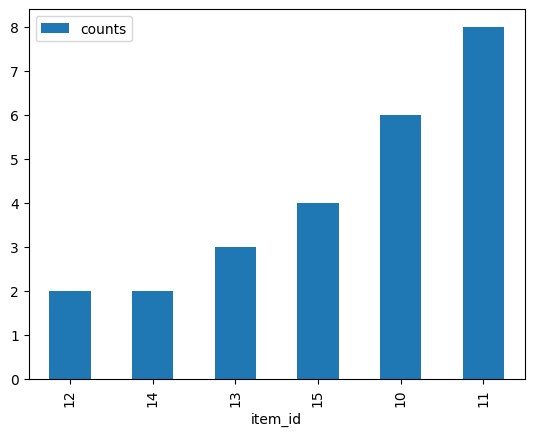

In [25]:
draw_distribution(data)

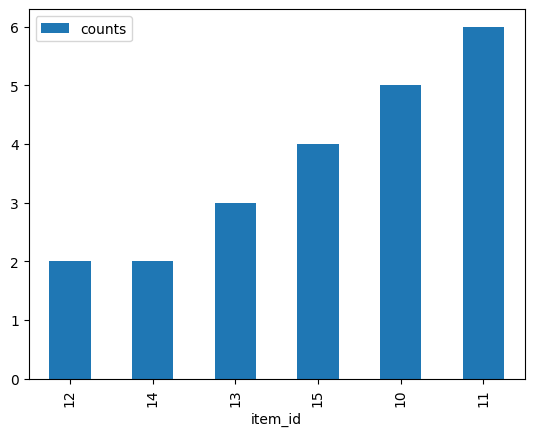

In [26]:
draw_distribution(result)

In [5]:
filter = PercentileItemsFilter(0.7, query_column="user_id")
result = filter.transform(data)
result

/tmp/ipykernel_5549/776507398.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_tail["num_items_to_delete"] = self.items_proportion * (
/tmp/ipykernel_5549/776507398.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_tail["num_items_to_delete"] = short_tail["num_items_to_delete"].astype("int")


,user_id,item_id
3,0,12
4,0,15
8,2,13
9,2,14
10,3,15
11,3,13
15,4,14
17,5,12
18,5,13
19,5,15


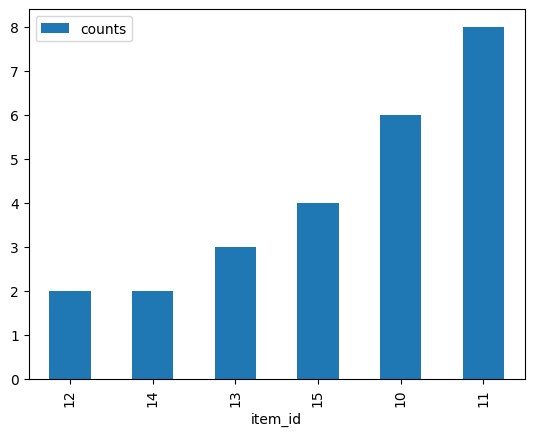

In [6]:
draw_distribution(data)

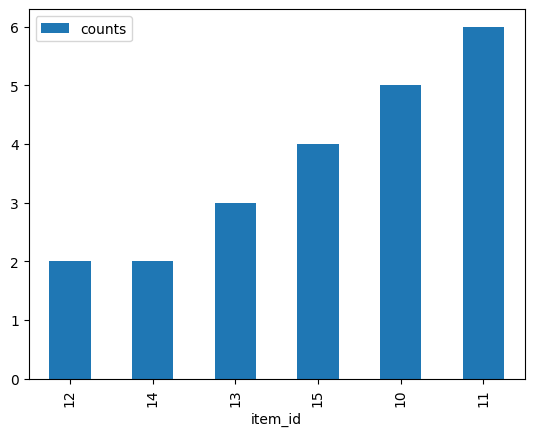

In [7]:
draw_distribution(result)

### movielens1m

In [27]:
!pip install rs-datasets

In [28]:
from rs_datasets import MovieLens

In [29]:
movielens = MovieLens("20m")
interactions = movielens.ratings

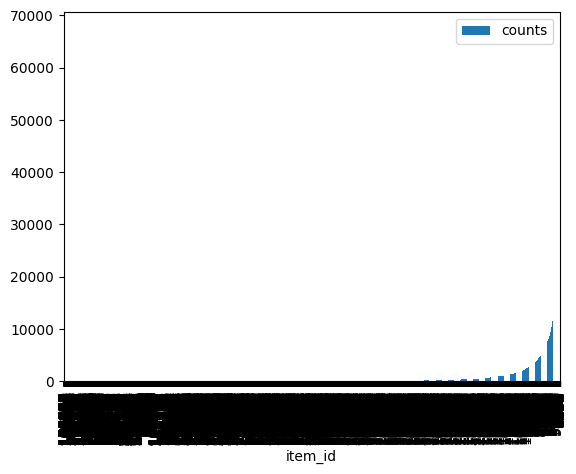

In [17]:
draw_distribution(interactions)

In [19]:
filter = PercentileItemsFilter(0.7, query_column="user_id")

In [20]:
%%timeit

result = filter.transform(interactions)

/tmp/ipykernel_5549/776507398.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_tail["num_items_to_delete"] = self.items_proportion * (
/tmp/ipykernel_5549/776507398.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_tail["num_items_to_delete"] = short_tail["num_items_to_delete"].astype("int")
/tmp/ipykernel_5549/776507398.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

10.6 s ± 15.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
result = filter.transform(interactions)

/tmp/ipykernel_5549/776507398.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_tail["num_items_to_delete"] = self.items_proportion * (
/tmp/ipykernel_5549/776507398.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_tail["num_items_to_delete"] = short_tail["num_items_to_delete"].astype("int")


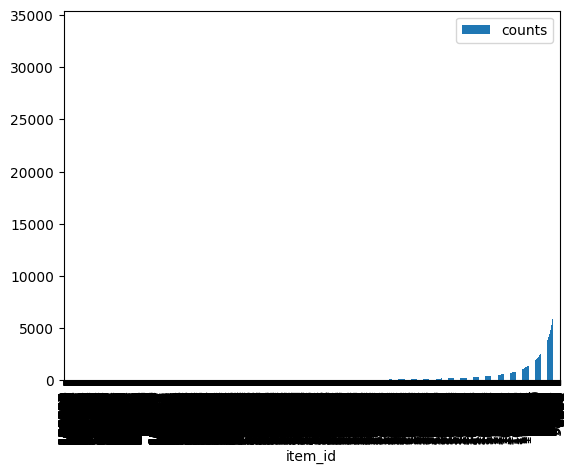

In [26]:
draw_distribution(result)

In [27]:
interactions.groupby("item_id").size().reset_index().rename(columns={0: "counts"}).sort_values("counts")

,item_id,counts
26743,131262,1
16663,84436,1
16664,84442,1
16683,84500,1
16694,84534,1
...,...,...
476,480,59715
587,593,63299
315,318,63366
352,356,66172


In [28]:
result.groupby("item_id").size().reset_index().rename(columns={0: "counts"}).sort_values("counts")

,item_id,counts
26743,131262,1
16663,84436,1
16664,84442,1
16683,84500,1
16694,84534,1
...,...,...
476,480,29919
587,593,31711
315,318,31745
352,356,33148


In [33]:
filter = PercentileItemsFilter2(0.7, query_column="user_id")

In [34]:
%%timeit

result = filter.transform(interactions)

/tmp/ipykernel_2305/3578101672.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_tail["num_items_to_delete"] = self.items_proportion * (
/tmp/ipykernel_2305/3578101672.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_tail["num_items_to_delete"] = short_tail["num_items_to_delete"].astype("int")
/tmp/ipykernel_2305/3578101672.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

12 s ± 25.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
result = filter.transform(interactions)

/tmp/ipykernel_2305/3578101672.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_tail["num_items_to_delete"] = self.items_proportion * (
/tmp/ipykernel_2305/3578101672.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_tail["num_items_to_delete"] = short_tail["num_items_to_delete"].astype("int")


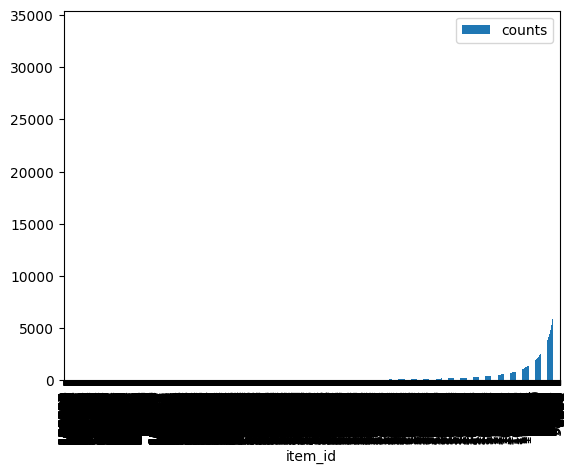

In [37]:
draw_distribution(result)

In [38]:
result.groupby("item_id").size().reset_index().rename(columns={0: "counts"}).sort_values("counts")

,item_id,counts
26743,131262,1
16663,84436,1
16664,84442,1
16683,84500,1
16694,84534,1
...,...,...
476,480,29919
587,593,31711
315,318,31745
352,356,33148
